In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/mvsa/* /content/

In [ ]:
!unzip data.zip -d /content/

# Multimodal Sentiment Analysis with Transformer Model
This notebook demonstrates a multimodal sentiment analysis approach using DeBERTa for text encoding, DenseNet for image encoding, and a Transformer model for feature fusion. The goal is to classify tweets present in MVSA Single dataset based on text and images into sentiment categories: "Positive," "Neutral," and "Negative." Key metrics tracked include accuracy, F1-score, and loss over training epochs, with the best-performing models saved.



# Setup and Imports
We start by importing the necessary libraries, setting up CUDA for GPU debugging, and initializing device settings.


In [ ]:
!pip install torch-geometric
# Enable CUDA debugging if available
%env CUDA_LAUNCH_BLOCKING=1

import os
import shutil
import torch
import torch.nn as nn
import pandas as pd
from transformers import DebertaV2Tokenizer, DebertaV2Model
from torchvision import models, transforms
import torchvision
from torch_geometric.loader import DataLoader
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import os
import shutil
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.2 MB/s eta 0:00:00
env: CUDA_LAUNCH_BLOCKING=1


# Dataset Loading and Preprocessing
We load the dataset and preprocess it to filter out errors and missing values.

In [ ]:
class TextDataProcessor:

  def __init__(self, label_path, text_store_path):
    self.ids = None
    self.labels = None
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.labels_path = label_path
    self.text_store_path = text_store_path

  def read_text_dataset(self):
    texts = []
    for text_id in self.ids.values:
      filepath = os.path.join(self.text_store_path, f"{text_id}.txt")
      with open(filepath, 'r', errors="replace") as file:
        content = file.read()
        texts.append(content)
    return texts

  def get_text_with_same_labels(self):
    df_labels = pd.read_csv(self.labels_path)
    df_labels_with_same_annotation = df_labels[(df_labels['text'] == df_labels['image'])]
    self.labels = df_labels_with_same_annotation['text']
    self.ids = df_labels_with_same_annotation['ID']
    texts = self.read_text_dataset()
    return texts, self.labels


class ImageDataProcessor:
  def __init__(self, label_path, image_store_path):
    self.ids = None
    self.labels = None
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.labels_path = label_path
    self.image_store_path = image_store_path

  def load_image_dataset(self):
    images = [ f"{img_id}.jpg" for img_id in self.ids.values]
    return images

  def get_image_with_same_labels(self):
    df_labels = pd.read_csv(self.labels_path)
    df_labels_with_same_annotation = df_labels[(df_labels['text'] == df_labels['image'])]
    self.labels = df_labels_with_same_annotation['image']
    self.ids = df_labels_with_same_annotation['ID']
    images = self.load_image_dataset()
    return images, self.labels


class MultiModalDataProcessor:
  def __init__(self, texts, imgs, labels):
    self.texts = texts
    self.imgs = imgs
    self.labels = labels

  def shuffle(self):
    texts_array = np.array(self.texts)
    img_array = np.array(self.imgs)
    labels = self.labels.map({"positive": 2, "negative": 0, "neutral": 1}).to_numpy()

    concatenated_array = np.column_stack((labels, texts_array, img_array))
    # np.random.shuffle(concatenated_array)

    return pd.DataFrame(concatenated_array, columns=['Label', 'Content', 'Image_Name'])

In [ ]:
label_path = "/content/data/MVSA_Single/labelResultAll.csv"
text_path = "/content/data/MVSA_Single/data/texts"
image_path = "/content/data/MVSA_Single/data/images"

texts, labels = TextDataProcessor(label_path, text_path).get_text_with_same_labels()
image_list, labels = ImageDataProcessor(label_path, image_path).get_image_with_same_labels()
data = MultiModalDataProcessor(texts, image_list, labels).shuffle()

# Dataset EDA
Here we try to find out our distribution of our data

In [ ]:
data.head()

,Label,Content,Image_Name
0,2,#escort We have a young and energetic team and...,4.jpg
1,2,"RT @chrisashaffer: Went to SSC today to be a ""...",5.jpg
2,2,"RT @babeshawnmendes: ""that was really energeti...",6.jpg
3,2,"RT @deepikapadukone: To my most hard working,f...",7.jpg
4,2,Look at their Photo and feel the #Anger. #Spea...,9.jpg


In [ ]:
# Split majority and minority classes
majority_class = data[data['Label'] == '2']
minority_class_1 = data[data['Label'] == '1']
minority_class_2 = data[data['Label'] == '0']

# Downsample majority class
majority_downsampled = resample(majority_class,
                                 replace=False,  # sample without replacement
                                 n_samples=len(minority_class_2),  # match minority class size
                                 random_state=42)

# Combine minority and downsampled majority
df_balanced = pd.concat([majority_downsampled, minority_class_1, minority_class_2])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

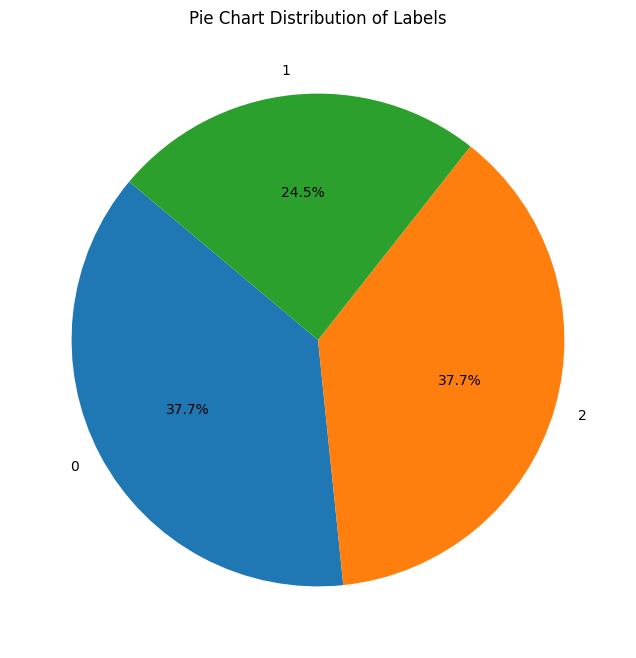

Label
0    724
2    724
1    470
Name: count, dtype: int64


In [ ]:
df = df_balanced
label_counts = df['Label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Pie Chart Distribution of Labels")
plt.show()
print(df_balanced.Label.value_counts())

1. **Text Preprocessing**

    We tokenize text data using the DeBERTa tokenizer with padding and truncation for consistent input size.


In [ ]:
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")

def preprocess_text(text):
    encoding = tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt")
    return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

2. **Image Preprocessing**
    
   Image transformations include resizing, normalization, and random augmentations to improve model generalization.



In [ ]:
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_name):
    if pd.isna(image_name) or not isinstance(image_name, str):
        return torch.zeros(3, 224, 224)
    image_path = os.path.join("/content/data/MVSA_Single/data/images/", image_name)  # Update path accordingly
    try:
        image = Image.open(image_path).convert("RGB")
        return image_transform(image)
    except FileNotFoundError:
        return torch.zeros(3, 224, 224)

# Model Architecture

1. **Text Encoder (DeBERTa)**
    
    The text encoder uses a DeBERTaV3 model with a dropout layer. We initially freeze DeBERTa layers for faster training.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.deberta = DebertaV2Model.from_pretrained("microsoft/deberta-v3-large")
        self.proj = nn.Linear(1024, 768)  # Project DeBERTaV3 output to 512-dim

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        return self.proj(outputs[:, 0, :])  # Use [CLS] token for text representation

2. **Image Encoder (DenseNet-121)**

    The image encoder is built on a pre-trained DenseNet model, extracting image features with dropout for regularization.

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        densenet = models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
        self.features = densenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj = nn.Linear(1024, 768)  # Reduce image focus with DenseNet-121 and project to 512-dim

    def forward(self, images):
        features = self.features(images)
        pooled = self.avgpool(features).view(features.size(0), -1)
        return self.proj(pooled)  # Project to 768-dim

3. **Multimodal Transformer Model**
    
    This model fuses text and image features via a Transformer encoder for classification.

In [ ]:
class MultimodalTransformerModel(nn.Module):
    def __init__(self, hidden_dim=768, output_dim=3):
        super(MultimodalTransformerModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_features, image_features):
        combined_features = torch.stack([text_features, image_features], dim=1)
        fused_features = self.transformer_encoder(combined_features).mean(dim=1)
        return self.classifier(fused_features)

# Dataset and Dataloader with Custom Collate Function
   We create a custom dataset class and collate function to handle dynamic padding for text input.


In [ ]:
class MVSADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text_input, attention_mask = preprocess_text(row["Content"])
        image_input = preprocess_image(row.get("Image_Name", None))
        label = torch.tensor(int(row["Label"]), dtype=torch.long)
        return {'input_ids': text_input, 'attention_mask': attention_mask, 'pixel_values': image_input}, label

    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    pixel_values = torch.stack([item['pixel_values'] for item in inputs])
    input_ids = pad_sequence([item['input_ids'] for item in inputs], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in inputs], batch_first=True)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask}, labels

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataset = MVSADataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

val_dataset = MVSADataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

test_dataset = MVSADataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Training Loop and Model-Saving Logic
In this training loop, we track and save the models with the highest accuracy and F1-score across epochs.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize Models, Optimizer, and Loss
text_encoder = TextEncoder().to(device)
image_encoder = ImageEncoder().to(device)
model = MultimodalTransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
num_epochs = 15

for param in image_encoder.features.parameters():
  param.requires_grad = False

for param in text_encoder.deberta.parameters():
  param.requires_grad = False

# Directories to save the best models
highest_acc_dir = "/content/highest_acc"
os.makedirs(highest_acc_dir, exist_ok=True)

# Initialize tracking variables for highest metrics
best_accuracy = 0.0

# Training loop with model-saving logic
history = {'epoch': [],
           'train_loss': [],
           'train_accuracy': [],
           'train_f1_score': [],
           'val_loss': [],
           'val_accuracy': [],
           'val_f1_score': []
           }

for epoch in range(num_epochs):  # Adjust epochs as needed
    print(f"\n=================== Epoch {epoch + 1} ====================")
    model.train()
    total_loss, correct_predictions, total_samples = 0, 0, 0
    all_preds, all_labels = [], []

    # Train step
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        input_ids, attention_mask, pixel_values = [inputs[key].to(device) for key in ['input_ids', 'attention_mask', 'pixel_values']]
        labels = labels.to(device)

        text_features = text_encoder(input_ids, attention_mask)
        image_features = image_encoder(pixel_values)

        outputs = model(text_features, image_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    train_f1 = f1_score(all_labels, all_preds, average="weighted")

    scheduler.step(train_f1)

    model.eval()
    text_encoder.eval()
    image_encoder.eval()
    total_loss, correct_predictions, total_samples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.inference_mode():
      for batch in tqdm(val_dataloader):
        inputs, labels = batch
        input_ids, attention_mask, pixel_values = [inputs[key].to(device) for key in ['input_ids', 'attention_mask', 'pixel_values']]
        labels = labels.to(device)

        text_features = text_encoder(input_ids, attention_mask)
        image_features = image_encoder(pixel_values)

        outputs = model(text_features, image_features)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


    val_loss = total_loss / len(val_dataloader)
    val_accuracy = correct_predictions / total_samples
    val_f1 = f1_score(all_labels, all_preds, average="weighted")

    # Save to history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['train_f1_score'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_f1_score'].append(val_f1)

    with open("training_history.json", "w") as f:
      json.dump(history, f)

    # Check for new highest accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        shutil.rmtree(highest_acc_dir)
        os.makedirs(highest_acc_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(highest_acc_dir, "best_accuracy_model.pth"))
        print(f"New best accuracy model saved with accuracy: {best_accuracy:.4f}")

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1 Score: {train_f1:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1 Score: {val_f1:.4f}")

Using device: cuda


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 64.9MB/s]



=================== Epoch 1 ====================


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.5513
Train Loss: 1.0162 | Train Accuracy: 0.5281 | Train F1 Score: 0.3955 | Validation Loss: 0.9754 | Validation Accuracy: 0.5513 | Validation F1 Score: 0.4425

=================== Epoch 2 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.5812
Train Loss: 0.9601 | Train Accuracy: 0.5353 | Train F1 Score: 0.4270 | Validation Loss: 0.9451 | Validation Accuracy: 0.5812 | Validation F1 Score: 0.4621

=================== Epoch 3 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.5855
Train Loss: 0.9054 | Train Accuracy: 0.5834 | Train F1 Score: 0.4917 | Validation Loss: 0.8978 | Validation Accuracy: 0.5855 | Validation F1 Score: 0.4729

=================== Epoch 4 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.5940
Train Loss: 0.8719 | Train Accuracy: 0.5949 | Train F1 Score: 0.5212 | Validation Loss: 0.8487 | Validation Accuracy: 0.5940 | Validation F1 Score: 0.5260

=================== Epoch 5 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.6282
Train Loss: 0.8398 | Train Accuracy: 0.6282 | Train F1 Score: 0.5848 | Validation Loss: 0.8298 | Validation Accuracy: 0.6282 | Validation F1 Score: 0.5892

=================== Epoch 6 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.8137 | Train Accuracy: 0.6444 | Train F1 Score: 0.6134 | Validation Loss: 0.8586 | Validation Accuracy: 0.6068 | Validation F1 Score: 0.5460

=================== Epoch 7 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.7859 | Train Accuracy: 0.6468 | Train F1 Score: 0.6196 | Validation Loss: 0.8305 | Validation Accuracy: 0.6282 | Validation F1 Score: 0.6054

=================== Epoch 8 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.6453
Train Loss: 0.7647 | Train Accuracy: 0.6640 | Train F1 Score: 0.6411 | Validation Loss: 0.8252 | Validation Accuracy: 0.6453 | Validation F1 Score: 0.6299

=================== Epoch 9 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.7374 | Train Accuracy: 0.6830 | Train F1 Score: 0.6661 | Validation Loss: 0.8428 | Validation Accuracy: 0.6368 | Validation F1 Score: 0.6239

=================== Epoch 10 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.7236 | Train Accuracy: 0.6973 | Train F1 Score: 0.6821 | Validation Loss: 0.8449 | Validation Accuracy: 0.6282 | Validation F1 Score: 0.6177

=================== Epoch 11 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.7074 | Train Accuracy: 0.7016 | Train F1 Score: 0.6908 | Validation Loss: 0.8244 | Validation Accuracy: 0.6325 | Validation F1 Score: 0.6228

=================== Epoch 12 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

New best accuracy model saved with accuracy: 0.6496
Train Loss: 0.6816 | Train Accuracy: 0.7173 | Train F1 Score: 0.7058 | Validation Loss: 0.8659 | Validation Accuracy: 0.6496 | Validation F1 Score: 0.6426

=================== Epoch 13 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.6646 | Train Accuracy: 0.7259 | Train F1 Score: 0.7157 | Validation Loss: 0.8036 | Validation Accuracy: 0.6239 | Validation F1 Score: 0.6124

=================== Epoch 14 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.6567 | Train Accuracy: 0.7245 | Train F1 Score: 0.7173 | Validation Loss: 0.8210 | Validation Accuracy: 0.6368 | Validation F1 Score: 0.6267

=================== Epoch 15 ====================


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.6343 | Train Accuracy: 0.7350 | Train F1 Score: 0.7277 | Validation Loss: 0.8633 | Validation Accuracy: 0.6282 | Validation F1 Score: 0.6121


### Testing model on test set

In [ ]:
correct_predictions, total_samples = 0, 0
all_preds_test, all_labels_test = [], []

model.eval()
text_encoder.eval()
image_encoder.eval()
with torch.inference_mode():
  for batch in tqdm(test_dataloader):
        inputs, labels = batch
        input_ids, attention_mask, pixel_values = [inputs[key].to(device) for key in ['input_ids', 'attention_mask', 'pixel_values']]
        labels = labels.to(device)

        text_features = text_encoder(input_ids, attention_mask)
        image_features = image_encoder(pixel_values)

        outputs = model(text_features, image_features)

        preds = torch.argmax(outputs, dim=1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())


  test_accuracy = correct_predictions / total_samples
  test_f1 = f1_score(all_labels_test, all_preds_test, average="weighted")

print(f"Test Accuracy: {test_accuracy:.4f} | Test F1 Score: {test_f1:.4f}")

  0%|          | 0/9 [00:00<?, ?it/s]

Test Accuracy: 0.6308 | Test F1 Score: 0.5926


# Model Performance Analysis
1. This section includes plotting training history, confusion matrix, classification report, and ROC-AUC curves.
2. Visualizations help interpret the model’s performance by class and highlight areas for improvement.


Training History:
    epoch  train_loss  train_accuracy  train_f1_score  val_loss  val_accuracy  \
0       1    1.016243        0.528122        0.395496  0.975397      0.551282   
1       2    0.960076        0.535272        0.427008  0.945148      0.581197   
2       3    0.905418        0.583413        0.491695  0.897832      0.585470   
3       4    0.871894        0.594852        0.521162  0.848660      0.594017   
4       5    0.839810        0.628217        0.584769  0.829847      0.628205   
5       6    0.813723        0.644423        0.613417  0.858625      0.606838   
6       7    0.785855        0.646806        0.619632  0.830537      0.628205   
7       8    0.764735        0.663966        0.641147  0.825203      0.645299   
8       9    0.737383        0.683031        0.666078  0.842779      0.636752   
9      10    0.723558        0.697331        0.682067  0.844913      0.628205   
10     11    0.707429        0.701621        0.690773  0.824352      0.632479   
11     12

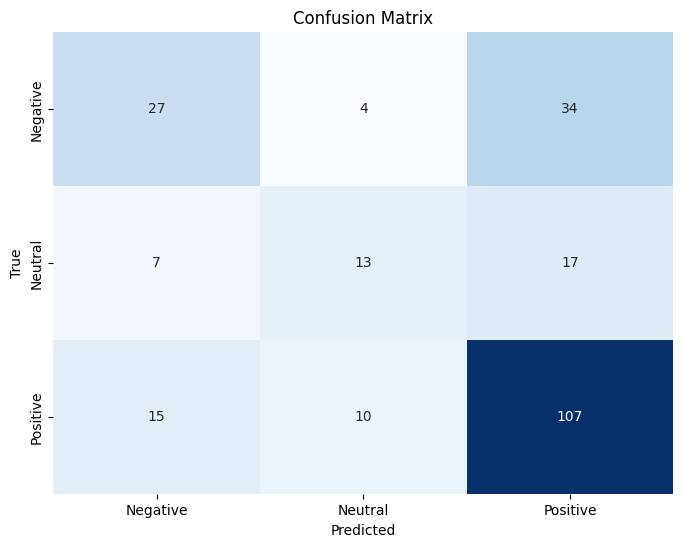


Errors by Class:
          Total Errors
Negative            38
Positive            25
Neutral             24

Classification Report:
              precision    recall  f1-score     support
Negative       0.551020  0.415385  0.473684   65.000000
Neutral        0.481481  0.351351  0.406250   37.000000
Positive       0.677215  0.810606  0.737931  132.000000
accuracy       0.628205  0.628205  0.628205    0.628205
macro avg      0.569906  0.525781  0.539288  234.000000
weighted avg   0.611212  0.628205  0.612084  234.000000


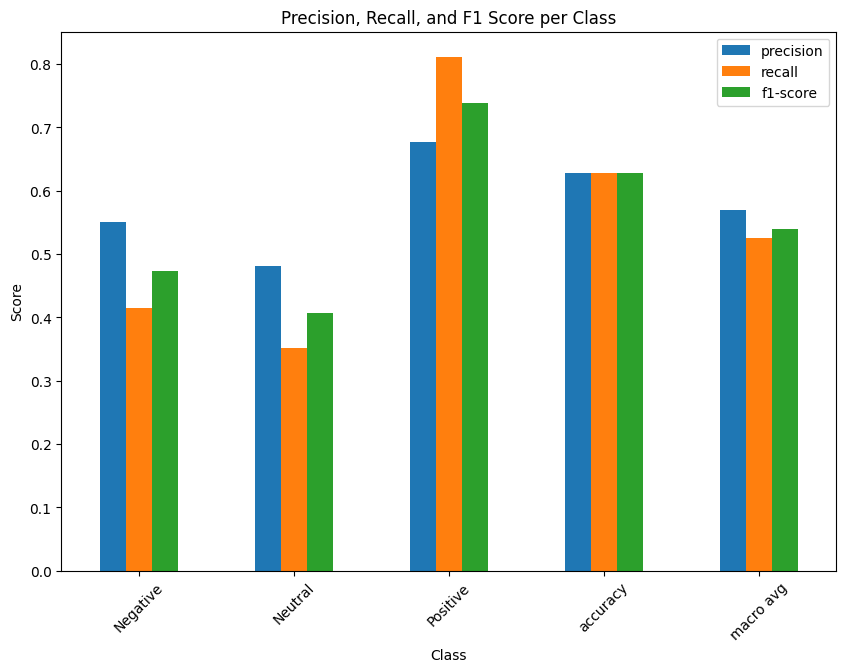

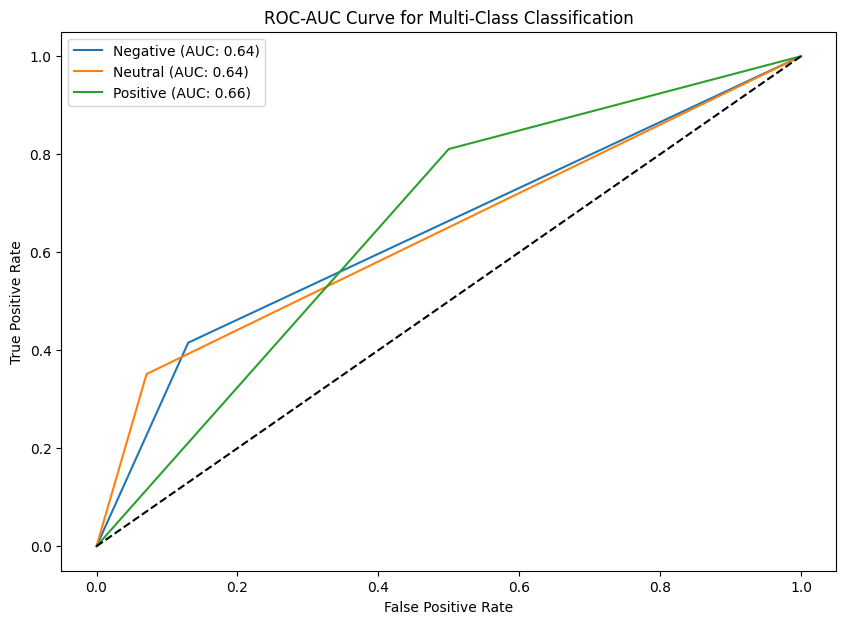

In [ ]:
# EDA: Convert history to DataFrame for analysis
history_df = pd.DataFrame(history)
print("\nTraining History:")
print(history_df)
history_df.to_csv("Training_history.csv", index=False)
# EDA Part - Model Performance Analysis

# 1. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"],)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Error Analysis by Class
errors = pd.DataFrame(conf_matrix, index=["Negative", "Neutral", "Positive"],
                      columns=["Negative", "Neutral", "Positive"])
errors['Total Errors'] = errors.sum(axis=1) - np.diag(errors)
print("\nErrors by Class:")
print(errors[['Total Errors']].sort_values(by='Total Errors', ascending=False))

# 3. Classification Report
report = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)

# Plot Precision, Recall, and F1 Score per Class
metrics = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude support and accuracy row
metrics.plot(kind='bar', figsize=(10, 7))
plt.title("Precision, Recall, and F1 Score per Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

# 4. ROC-AUC Curve for Multi-Class Classification
y_true = label_binarize(all_labels, classes=[0, 1, 2, 3])
y_scores = label_binarize(all_preds, classes=[0, 1, 2, 3])

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC: {roc_auc_score(y_true[:, i], y_scores[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Multi-Class Classification")
plt.legend()
plt.show()

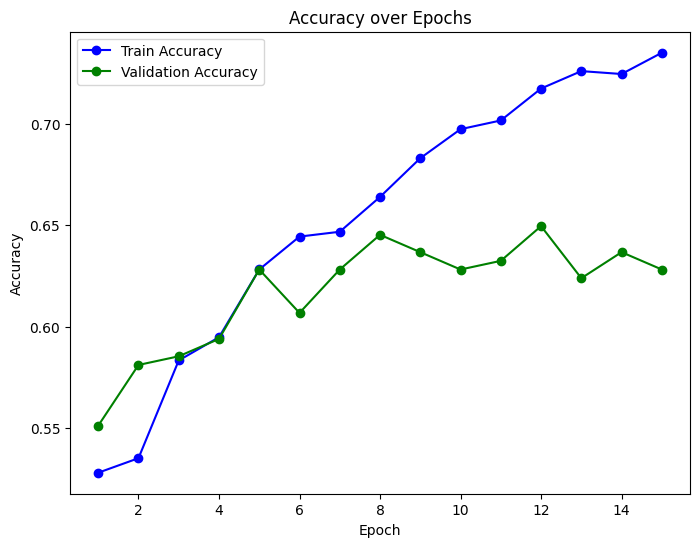

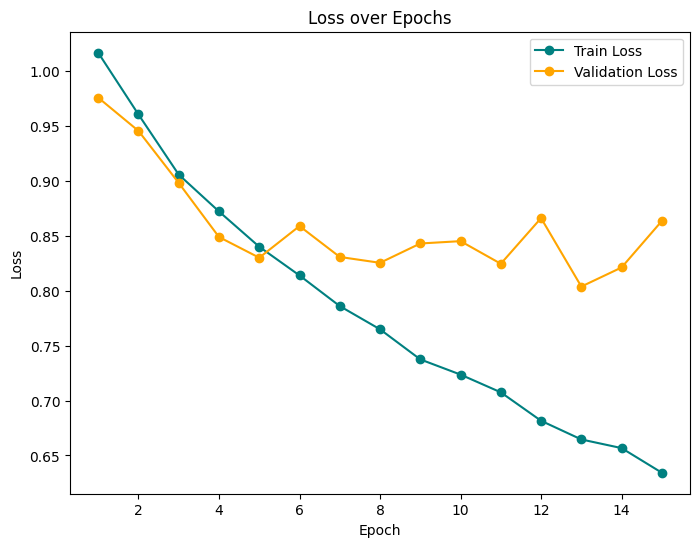

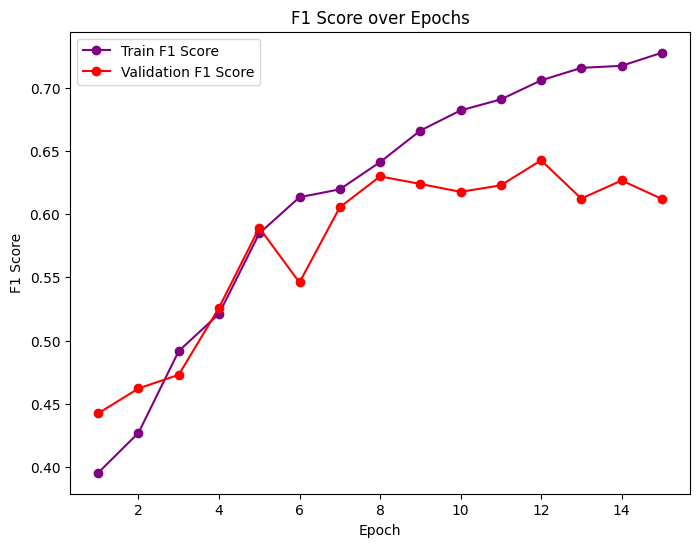

In [ ]:
with open('training_history.json', 'r') as f:
  history = json.load(f)


# Assuming `history` dictionary contains 'epoch', 'loss', 'accuracy', and 'f1_score'
# Convert history to DataFrame for easier plotting
history_df = pd.DataFrame(history)

# Plot Accuracy over Epochs
plt.figure(figsize=(8, 6))
plt.plot(history_df['epoch'][:15], history_df['train_accuracy'][:15], marker='o', label='Train Accuracy', color='b')
plt.plot(history_df['epoch'][:15], history_df['val_accuracy'][:15], marker='o', label='Validation Accuracy', color='g')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Plot Loss over Epochs
plt.figure(figsize=(8, 6))
plt.plot(history_df['epoch'][:15], history_df['train_loss'][:15], marker='o', label='Train Loss', color='teal')
plt.plot(history_df['epoch'][:15], history_df['val_loss'][:15], marker='o', label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

# Plot F1 Score over Epochs
plt.figure(figsize=(8, 6))
plt.plot(history_df['epoch'][:15], history_df['train_f1_score'][:15], marker='o', label='Train F1 Score', color='purple')
plt.plot(history_df['epoch'][:15], history_df['val_f1_score'][:15], marker='o', label='Validation F1 Score', color='r')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")
plt.legend()
plt.show()